<a href="https://colab.research.google.com/github/rafaeldsouza/mestrado-ReconhecimentoPadrao/blob/main/semana5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aluno:** Rafael de Souza Conceição

**Matéria:**Reconhecimento de Padrões - Francisco de Assis Boldt


Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

In [52]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor

0.6666666666666667

In [53]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
impurezaValor(X[:,0], y, 2.5),impurezaValor(X[:,1], y, 2.5)

((0.3333333333333333, 0.5, 0.0), (0.6666666666666667, 1, 0.6666666666666667))

In [54]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

In [55]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

In [56]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.93333333, 0.93333333, 0.8       , 0.93333333, 1.        ]),
 0.9200000000000002)

### Heuriscica

In [57]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza
melhorValor(X[:,0], y)

(2.475, 0.3333333333333333)

In [58]:
def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica(X,y))

(0, 2.475, 0.3333333333333333)


In [97]:
def ExecutarModelo(Modelos,xParam,yParam,allInformation=True):
  for modelo in Modelos: 
    modelo[0].fit(xParam,yParam)
    ypred = modelo[0].predict(xParam)
    scores = cross_validate(modelo[0], xParam, yParam)
    print(f"Modelo = {modelo[1]}")   
    print(f"mean score -> {np.mean(scores['test_score'])}")
    if allInformation:
      print(f"accuracy -> {accuracy_score(yParam, ypred)}")
      plotDecisao(modelo[0], xParam,yParam)
    print("-----------------------------------------------")
    print("-----------------------------------------------")
    
   
  #return accuracy_score(yParam, ypred), ypred

In [60]:
class ArvoreHeuristica(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreHeuristica()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreHeuristica()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y


### Resultados Iris

Modelo = Arvore
mean score -> 0.9200000000000002
accuracy -> 0.9533333333333334


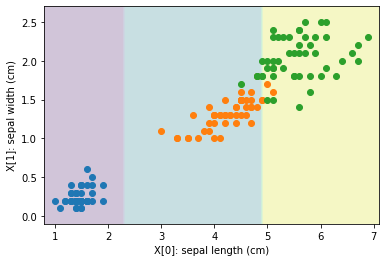

-----------------------------------------------
-----------------------------------------------
Modelo = Arvore Heuristica
mean score -> 0.9533333333333334
accuracy -> 0.9933333333333333


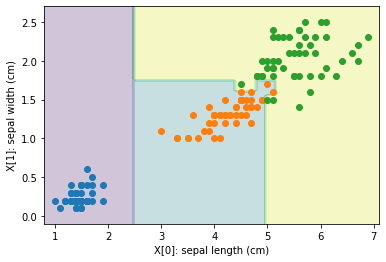

-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree GINI
mean score -> 0.9533333333333334
accuracy -> 0.9933333333333333


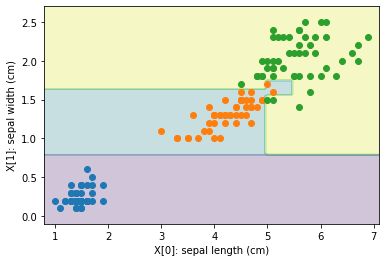

-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree ENTROPY
mean score -> 0.9533333333333334
accuracy -> 0.9933333333333333


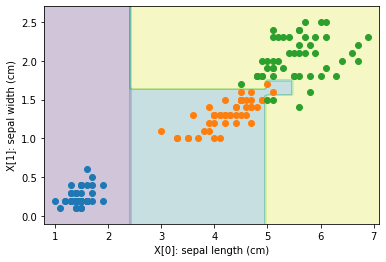

-----------------------------------------------
-----------------------------------------------


In [98]:
from sklearn.datasets import load_iris
iris = load_iris()
Xiris, yiris = iris.data[:,2:], iris.target
vetModelos = [[Arvore(),"Arvore"],[ArvoreHeuristica(),"Arvore Heuristica"],
              [DecisionTreeClassifier(criterion='gini'),"DecisionTree GINI"],
              [DecisionTreeClassifier(criterion='entropy'),"DecisionTree ENTROPY"]]
ExecutarModelo(vetModelos,Xiris,yiris)

### Resultados Wine

In [99]:
from sklearn.datasets import load_wine
wine = load_wine()

Xwine, ywine = wine.data, wine.target

In [100]:
Xwine.shape,ywine.shape

((178, 13), (178,))

In [101]:
ExecutarModelo(vetModelos,Xwine,ywine,False)

Modelo = Arvore
mean score -> 0.5958730158730159
-----------------------------------------------
-----------------------------------------------
Modelo = Arvore Heuristica
mean score -> 0.8942857142857144
-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree GINI
mean score -> 0.8765079365079365
-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree ENTROPY
mean score -> 0.8992063492063492
-----------------------------------------------
-----------------------------------------------


### Resultado Breast Cancer

In [102]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
Xbc, ybc = breast_cancer.data, breast_cancer.target
ExecutarModelo(vetModelos,Xbc,ybc,False)

Modelo = Arvore
mean score -> 0.815463437354448
-----------------------------------------------
-----------------------------------------------
Modelo = Arvore Heuristica
mean score -> 0.9191429902189101
-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree GINI
mean score -> 0.9103244837758112
-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree ENTROPY
mean score -> 0.9261915851575843
-----------------------------------------------
-----------------------------------------------


### Resultado Digits

In [103]:

from sklearn.datasets import load_digits
digitis = load_digits()
Xd, yd = digitis.data, digitis.target
ExecutarModelo(vetModelos,Xd,yd,False)

Modelo = Arvore
mean score -> 0.10128133704735376
-----------------------------------------------
-----------------------------------------------
Modelo = Arvore Heuristica
mean score -> 0.7974636335499845
-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree GINI
mean score -> 0.7885793871866296
-----------------------------------------------
-----------------------------------------------
Modelo = DecisionTree ENTROPY
mean score -> 0.8124976787372331
-----------------------------------------------
-----------------------------------------------


## Conclusão


Ao analisar os resultados da base Iris, obtive dados muitos parecidos da as arvores de decisão heristica desenvolvida com as do sklearn, porem como o resultado se aprocimaram muito do 100% acreito que pode ter ocorrido um superajustamento que pode ter ocorrido por falta de um tratamento nos dados.

Os resultados obtidos com os outros dataset mostraram resultados com um pouco mais de variações e por ter usado dataset com mais caracteristicas os dados sofreram menos com o superajustamento.